<a href="https://colab.research.google.com/github/Mahshid-git/Emotions/blob/main/02_Model/model_doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")
%cd '/content/drive/MyDrive/Emotions/'

Mounted at /content/drive
/content/drive/MyDrive/Emotions


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec, doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('clean_text_final.csv')
data = data[['text', 'label', 'clean_text']]
data.tail()

,text,label,clean_text
416788,i feel like telling these horny devils to find...,2,feel like tell horny devil find site suit sort...
416789,i began to realize that when i was feeling agi...,3,begin realize feel agitate restless think go dish
416790,i feel very curious be why previous early dawn...,5,feel curious previous early dawn time seek tro...
416791,i feel that becuase of the tyranical nature of...,3,feel because tyrannical nature government el s...
416792,i think that after i had spent some time inves...,5,think spend time investigate surround things s...


In [6]:
X = data['clean_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [7]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled
# X_train, X_test, y_train, y_test = train_test_split(data.post, data.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [10]:
all_data[0]

TaggedDocument(words=['feel', 'keen', 'edge', 'begin', 'bite'], tags=['Train_0'])

When training the doc2vec, we will vary the following parameters:

dm=0 , distributed bag of words (DBOW) is used. \
vector_size=300 , 300 vector dimensional feature vectors. \
negative=5 , specifies how many “noise words” should be drawn. \
min_count=1, ignores all words with total frequency lower than this. \
alpha=0.065 , the initial learning rate.

In [8]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002  # reducing learning rate for each new epoch
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 416793/416793 [00:00<00:00, 1833388.97it/s]


Next, we get vectors from trained doc2vec model.

In [9]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [17]:
train_vectors_dbow[0].shape

(300,)

# Logistic Regression on doc2vec

In [10]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
# logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [11]:
class_to_emotion = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotions = class_to_emotion.values()

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.6450157870996842
              precision    recall  f1-score   support

     sadness       0.64      0.71      0.67     30296
         joy       0.67      0.77      0.72     35266
        love       0.54      0.34      0.41      8639
       anger       0.64      0.54      0.58     14328
        fear       0.64      0.53      0.58     11927
    surprise       0.58      0.44      0.50      3743

    accuracy                           0.65    104199
   macro avg       0.62      0.55      0.58    104199
weighted avg       0.64      0.65      0.64    104199



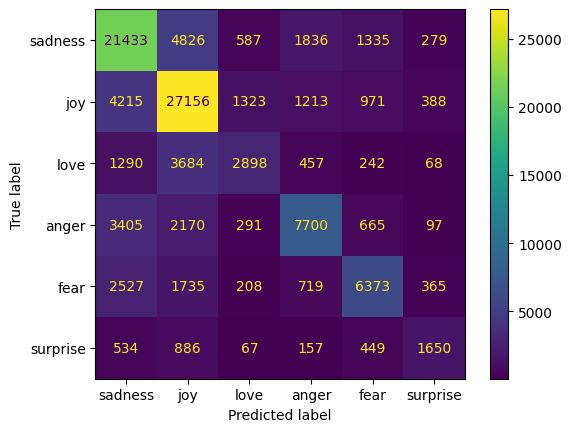

In [12]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [13]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.7075
Accuracy of Class 1 (joy): 0.7700
Accuracy of Class 2 (love): 0.3355
Accuracy of Class 3 (anger): 0.5374
Accuracy of Class 4 (fear): 0.5343
Accuracy of Class 5 (surprise): 0.4408


# Naive Bayes

In [17]:
# nb = MultinomialNB()
# nb.fit(train_vectors_dbow, y_train)
# y_pred = nb.predict(test_vectors_dbow)

ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
# disp.plot()

In [ ]:
# # per class accuracy
# per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

# for i, acc_i in enumerate(per_cls_acc):
#         print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

# SGD

In [20]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(train_vectors_dbow, y_train)
y_pred = sgd.predict(test_vectors_dbow)

In [23]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.5847848827723875
              precision    recall  f1-score   support

     sadness       0.57      0.73      0.64     30296
         joy       0.59      0.84      0.69     35266
        love       0.38      0.06      0.10      8639
       anger       0.60      0.32      0.42     14328
        fear       0.65      0.34      0.44     11927
    surprise       0.42      0.07      0.12      3743

    accuracy                           0.58    104199
   macro avg       0.54      0.39      0.40    104199
weighted avg       0.57      0.58      0.54    104199



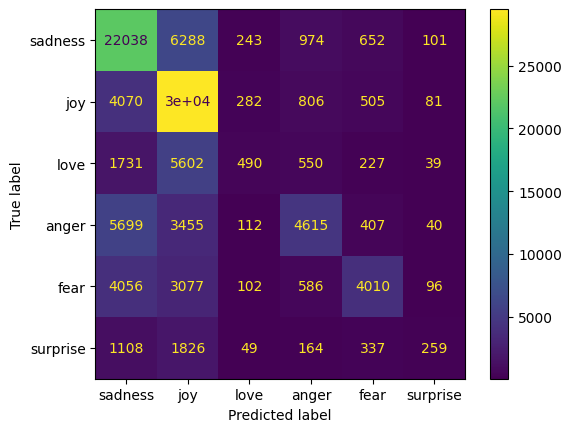

In [21]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [22]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.7274
Accuracy of Class 1 (joy): 0.8371
Accuracy of Class 2 (love): 0.0567
Accuracy of Class 3 (anger): 0.3221
Accuracy of Class 4 (fear): 0.3362
Accuracy of Class 5 (surprise): 0.0692


# KNN (n=5)

In [25]:
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(train_vectors_dbow, y_train)
y_pred = knn.predict(test_vectors_dbow)

In [26]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.6988646724056853
              precision    recall  f1-score   support

     sadness       0.69      0.80      0.74     30296
         joy       0.72      0.81      0.76     35266
        love       0.58      0.48      0.53      8639
       anger       0.72      0.59      0.65     14328
        fear       0.71      0.52      0.60     11927
    surprise       0.62      0.36      0.46      3743

    accuracy                           0.70    104199
   macro avg       0.67      0.59      0.62    104199
weighted avg       0.70      0.70      0.69    104199



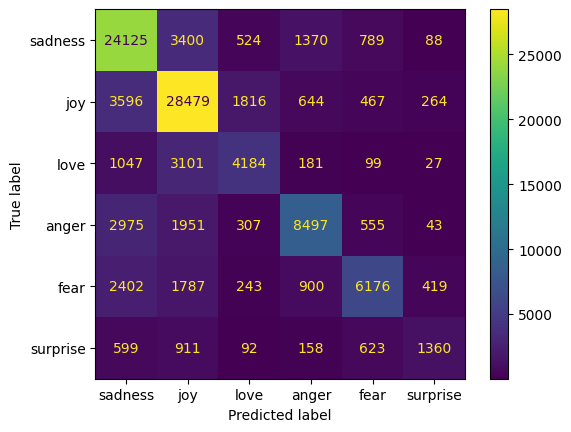

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [28]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.7963
Accuracy of Class 1 (joy): 0.8075
Accuracy of Class 2 (love): 0.4843
Accuracy of Class 3 (anger): 0.5930
Accuracy of Class 4 (fear): 0.5178
Accuracy of Class 5 (surprise): 0.3633


# Random Forest

In [33]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5)
rf.fit(train_vectors_dbow, y_train)
y_pred = rf.predict(test_vectors_dbow)

In [31]:

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))

accuracy 0.45641512874403783
              precision    recall  f1-score   support

     sadness       0.46      0.52      0.49     30296
         joy       0.46      0.90      0.61     35266
        love       0.00      0.00      0.00      8639
       anger       0.00      0.00      0.00     14328
        fear       0.00      0.00      0.00     11927
    surprise       0.00      0.00      0.00      3743

    accuracy                           0.46    104199
   macro avg       0.15      0.24      0.18    104199
weighted avg       0.29      0.46      0.35    104199



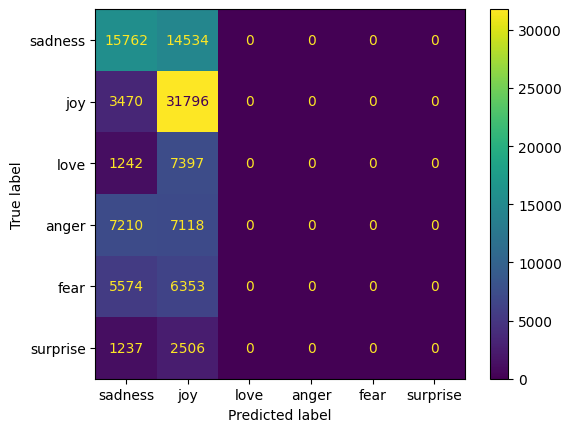

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=emotions)
disp.plot()

In [34]:
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

Accuracy of Class 0 (sadness): 0.5203
Accuracy of Class 1 (joy): 0.9016
Accuracy of Class 2 (love): 0.0000
Accuracy of Class 3 (anger): 0.0000
Accuracy of Class 4 (fear): 0.0000
Accuracy of Class 5 (surprise): 0.0000


# random Frest 2

In [38]:
rf = RandomForestClassifier(n_estimators=50, criterion='log_loss', max_depth=None, min_samples_leaf=100)
rf.fit(train_vectors_dbow, y_train)
y_pred = rf.predict(test_vectors_dbow)

In [39]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=emotions))
# per class accuracy
per_cls_acc = np.diagonal(cm/(cm.sum(axis=1))) # only the diagonal is important

for i, acc_i in enumerate(per_cls_acc):
        print("Accuracy of Class {} ({}): {:.4f}".format(i, class_to_emotion[i], acc_i))

accuracy 0.5006382019021296
              precision    recall  f1-score   support

     sadness       0.48      0.65      0.55     30296
         joy       0.50      0.88      0.64     35266
        love       0.94      0.00      0.01      8639
       anger       0.88      0.06      0.12     14328
        fear       0.85      0.06      0.11     11927
    surprise       1.00      0.00      0.01      3743

    accuracy                           0.50    104199
   macro avg       0.78      0.28      0.24    104199
weighted avg       0.64      0.50      0.41    104199

Accuracy of Class 0 (sadness): 0.5203
Accuracy of Class 1 (joy): 0.9016
Accuracy of Class 2 (love): 0.0000
Accuracy of Class 3 (anger): 0.0000
Accuracy of Class 4 (fear): 0.0000
Accuracy of Class 5 (surprise): 0.0000
